**Mount Google Drive for data accessing**

In [51]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install tensorflow_hub for using GoogLeNet(Inception V3) model**

In [0]:
!pip install -q tensorflow_hub

# GoogLeNet predicting test (before transfer learning)

**Setup**

In [53]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

'1.13.1'

**Dataset**

In [0]:
# need to add '/' before the path
data_root= '/content/drive/My Drive/maps'

In [55]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 400 images belonging to 4 classes.


In [56]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 4)


**Download the classifier**


*   Use *hub.module* to load a mobilenet, and *tf.keras.layers.Lambda* to wrap it up as a keras layer.

*   Any image classifier url from[ tfhub.dev](https://tfhub.dev/s?module-type=image-classification) will work here.






In [0]:
classifier_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/1"

In [0]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [59]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:15:36.415537 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________




*   Rebuild the data generator, with the output size set to match what's expected by the module.




In [60]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 400 images belonging to 4 classes.
Image batch shape:  (32, 299, 299, 3)
Labe batch shape:  (32, 4)




*   When using Keras, TFHub modules need to be manually initialized.




In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

**Run it on a single image**



*   Download a single image to try the model on.




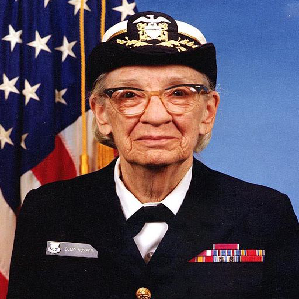

In [62]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [63]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(299, 299, 3)



*   Add a batch dimension, and pass the image to the model.



In [64]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)



*   The result is a 1001 element vector of logits, rating the probability of each class for the image.


*  So the top class ID can be found with argmax:



In [65]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653



**Decode the predictions **






*   We have the predicted class ID, Fetch the ImageNet labels, and decode the predictions




In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

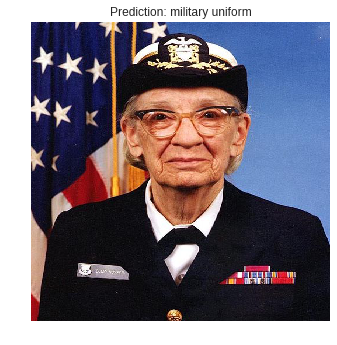

In [0]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

**Run it on a batch of images**

In [0]:
result_batch = classifier_model.predict(image_batch)

In [68]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['web site', 'jigsaw puzzle', 'jigsaw puzzle', 'jigsaw puzzle',
       'jigsaw puzzle', 'jigsaw puzzle', 'web site', 'jigsaw puzzle',
       'menu', 'web site', 'book jacket', 'envelope', 'jigsaw puzzle',
       'shower curtain', 'shower cap', 'web site', 'window shade',
       'web site', 'web site', 'jigsaw puzzle', 'jigsaw puzzle',
       'jigsaw puzzle', 'jigsaw puzzle', 'envelope', 'shower curtain',
       'envelope', 'solar dish', 'envelope', 'jellyfish', 'web site',
       'jigsaw puzzle', 'jigsaw puzzle'], dtype='<U30')



*   Check how these predictions line up with the images






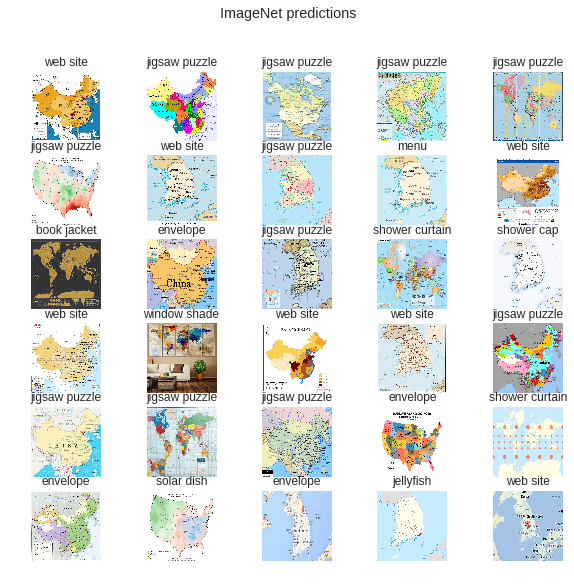

In [69]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Transfer Learning (Using Inception V3/GoogLeNet)



*   Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.




**Download the headless model**



*   TensorFlow Hub also distributes models without the top classification layer. 

*   Any image feature vector url from [tfhub.dev ](https://tfhub.dev/s?module-type=image-feature-vector)will work here.






In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"



*   Create the module, and check the expected image size:

The output for each image in the batch is a feature vector of size num_features = 2048.

For this module, the size of the input image is fixed to height x width = 299 x 299 pixels. The input images are expected to have color values in the range [0,1], following the common image input conventions.



In [0]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))



*   Ensure the data generator is generating images of the expected size:




In [72]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 400 images belonging to 4 classes.
Image batch shape:  (32, 299, 299, 3)
Labe batch shape:  (32, 4)




*   Wrap the module in a keras layer.




In [0]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])



*   Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.




In [0]:
features_extractor_layer.trainable = False

**Attach a classification head**



*   Now wrap the hub layer in a *tf.keras.Sequential* model, and add a new classification layer.




In [79]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:21:36.403065 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 8196      
Total params: 8,196
Trainable params: 8,196
Non-trainable params: 0
_________________________________________________________________


**Do not run!!**


*  ** Extra code:**
*   Add two layers



In [0]:
# MUST USE 'Dense', not 'dense'
hidden = tf.layers.Dense(10, activation='softmax')
output = tf.layers.Dense(image_data.num_classes, activation='softmax')

In [78]:
model = tf.keras.Sequential([
  features_extractor_layer,
  hidden,
  output
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:20:36.842905 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                20490     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 44        
Total params: 20,534
Trainable params: 20,534
Non-trainable params: 0
_________________________________________________________________


**End of Extra code**



*   Initialize the TFHub module.




In [0]:
init = tf.global_variables_initializer()
sess.run(init)



*   Test run a single batch, to see that the result comes back with the expected shape.




In [81]:
result = model.predict(image_batch)
result.shape

(32, 4)

**Train the model**



*   Use compile to configure the training process:




In [0]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])



*   Now use the* .fit* method to train the model.




In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [84]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=20, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/20
12/12 [==============================] - 7s 587ms/step - loss: 1.3130 - acc: 0.3913
Epoch 2/20
12/12 [==============================] - 9s 746ms/step - loss: 0.9082 - acc: 0.7214
Epoch 3/20
12/12 [==============================] - 10s 837ms/step - loss: 0.7008 - acc: 0.7799
Epoch 4/20
12/12 [==============================] - 11s 924ms/step - loss: 0.5805 - acc: 0.8478
Epoch 5/20
12/12 [==============================] - 10s 845ms/step - loss: 0.4934 - acc: 0.8995
Epoch 6/20
12/12 [==============================] - 10s 873ms/step - loss: 0.4489 - acc: 0.8913
Epoch 7/20
12/12 [==============================] - 10s 803ms/step - loss: 0.3525 - acc: 0.9484
Epoch 8/20
12/12 [==============================] - 11s 882ms/step - loss: 0.3364 - acc: 0.9429
Epoch 9/20
12/12 [==============================] - 10s 854ms/step - loss: 0.2944 - acc: 0.9565
Epoch 10/20
12/12 [==============================] - 10s 828ms/step - loss: 0.2769 - acc: 0.9484
Epoch 11/20
12/12 [======================



*   Model is making progress on the task.




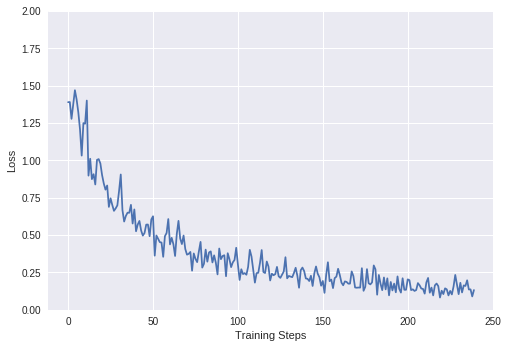

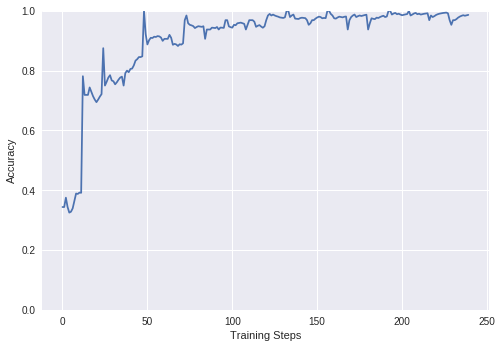

In [85]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

**Check the predictions**



*   Get the ordered list of class names:




In [86]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['China', 'South_Korea', 'United_States', 'World'], dtype='<U13')



*   Run the image batch through the model and comvert the indices to class names.




In [87]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['World', 'China', 'United_States', 'World', 'China', 'South_Korea',
       'South_Korea', 'China', 'World', 'South_Korea', 'China', 'China',
       'China', 'China', 'South_Korea', 'World', 'World', 'China',
       'World', 'United_States', 'World', 'United_States', 'China',
       'United_States', 'United_States', 'China', 'South_Korea',
       'South_Korea', 'South_Korea', 'United_States', 'China', 'World'],
      dtype='<U13')



*   Plot the result



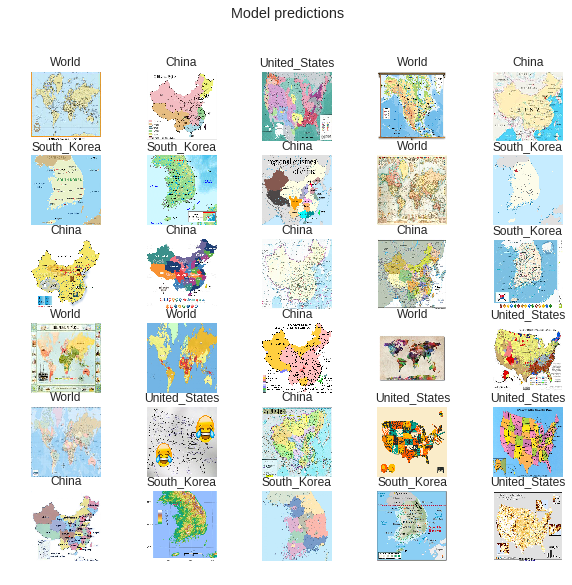

In [88]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [89]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:30:25.905914 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 18:30:28.747036 140602879338368 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 18:30:28.753382 140602879338368 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0403 18:30:28.768540 140602879338368 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0403 18:30:28.772823 140602879338368 export.py:587] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0403 18:30:28.779554 140602879338368 export.py:587] Signatures INCLUDED in export for Eval: None


W0403 18:30:28.783293 140602879338368 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0403 18:30:29.905083 140602879338368 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 18:30:29.907809 140602879338368 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:30:35.246739 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 18:30:37.194583 140602879338368 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 18:30:37.202400 140602879338368 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0403 18:30:37.208034 140602879338368 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0403 18:30:37.211106 140602879338368 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0403 18:30:37.214744 140602879338368 export.py:587] Signatures INCLUDED in export for Eval: ['eval']


W0403 18:30:37.218059 140602879338368 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0403 18:30:38.234927 140602879338368 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 18:30:38.238910 140602879338368 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 18:30:43.546419 140602879338368 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 18:30:45.276981 140602879338368 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 18:30:45.279222 140602879338368 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0403 18:30:45.293278 140602879338368 export.py:587] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0403 18:30:45.305864 140602879338368 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0403 18:30:45.315924 140602879338368 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0403 18:30:46.274176 140602879338368 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 18:30:46.276866 140602879338368 builder_impl.py:124] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/1554316188/saved_model.pb


I0403 18:30:47.053758 140602879338368 builder_impl.py:414] SavedModel written to: ./saved_models/1554316188/saved_model.pb


b'./saved_models/1554316188'